In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.
C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\yotam hermon\Anacond

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [4]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [5]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
#x=Dense(256,activation='relu')(x) #dense layer 4
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [6]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [7]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [8]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('../data/train/classification/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True)

Found 2970 images belonging to 2 classes.


In [9]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=5)


Epoch 1/5
92/92 [==============================] - 14s 152ms/step - loss: 0.4734 - accuracy: 0.8305
Epoch 2/5
92/92 [==============================] - 10s 111ms/step - loss: 0.3558 - accuracy: 0.8455
Epoch 3/5
92/92 [==============================] - 10s 111ms/step - loss: 0.3069 - accuracy: 0.8666
Epoch 4/5
92/92 [==============================] - 10s 112ms/step - loss: 0.2610 - accuracy: 0.8921s - loss: 0.2628 - accuracy: 0.89 - ETA: 0s - loss: 0.2614 - accuracy: 
Epoch 5/5
92/92 [==============================] - 10s 111ms/step - loss: 0.2566 - accuracy: 0.8972


In [10]:
print (model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [11]:
def validation(model, train_datagen):
    #model=Model(inputs=base_model.input,outputs=preds)
    #model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
    val_generator=train_datagen.flow_from_directory('../data/validation/', # this is where you specify the path to the main data folder
                                                     target_size=(224,224),
                                                     color_mode='rgb',
                                                     batch_size=32,
                                                     class_mode='categorical',                                                 
                                                     shuffle=True)

    step_size_val=val_generator.n//val_generator.batch_size
    history1 = model.fit_generator(generator=val_generator,
                       steps_per_epoch=step_size_val,
                       epochs=5)
    return history1

In [12]:
history1 = validation(model,train_datagen)

Found 120 images belonging to 2 classes.
Epoch 1/5
3/3 [==============================] - 1s 296ms/step - loss: 1.3270 - accuracy: 0.5909
Epoch 2/5
3/3 [==============================] - 0s 108ms/step - loss: 0.5635 - accuracy: 0.6591
Epoch 3/5
3/3 [==============================] - 0s 114ms/step - loss: 0.4910 - accuracy: 0.8125
Epoch 4/5
3/3 [==============================] - 0s 102ms/step - loss: 0.4333 - accuracy: 0.8636
Epoch 5/5
3/3 [==============================] - 0s 115ms/step - loss: 0.2442 - accuracy: 0.8864


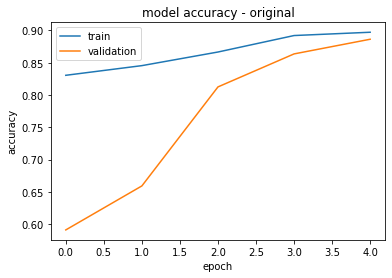

In [13]:
#history = model.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['accuracy'])
plt.plot(history1.history['accuracy'])
plt.title('model accuracy - original')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

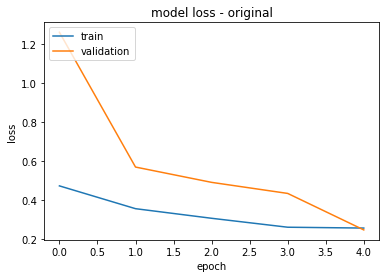

In [14]:
plt.plot(history.history['loss'])
plt.plot(history1.history['loss'])
plt.title('model loss - original')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
base_model2=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model2.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu',activity_regularizer=regularizers.l1(1e-5))(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu',activity_regularizer=regularizers.l1(1e-5))(x) #dense layer 2
x=Dense(512,activation='relu',activity_regularizer=regularizers.l1(1e-5))(x) #dense layer 3
#x=Dense(256,activation='relu')(x) #dense layer 4
preds=Dense(2,activation='softmax',activity_regularizer=regularizers.l1(1e-5))(x) #final layer with softmax activation

model2=Model(inputs=base_model2.input,outputs=preds)

for layer in model2.layers[:20]:
    layer.trainable=False
for layer in model2.layers[20:]:
    layer.trainable=True

train_datagen2=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator_noise=train_datagen2.flow_from_directory('../data/train/classification/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True)

model2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_noise=train_generator_noise.n//train_generator_noise.batch_size
history2 = model2.fit_generator(generator=train_generator_noise,
                   steps_per_epoch=step_size_noise,
                   epochs=5)

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Found 2970 images belonging to 2 classes.
Epoch 1/5
92/92 [==============================] - 12s 132ms/step - loss: 0.4934 - accuracy: 0.8346
Epoch 2/5
92/92 [==============================] - 10s 113ms/step - loss: 0.3840 - accuracy: 0.8407
Epoch 3/5
92/92 [==============================] - 10s 112ms/step - loss: 0.3293 - accuracy: 0.8662
Epoch 4/5
92/92 [==============================] - 10s 111ms/step - loss: 0.3040 - accuracy: 0.8819s - l
Epoch 5/5
92/92 [==============================] - 10s 112ms/step - loss: 0.2539 - accuracy: 0.9016


In [16]:
history_regulizerL1Val = validation(model2,train_datagen2)

Found 120 images belonging to 2 classes.
Epoch 1/5
3/3 [==============================] - 0s 109ms/step - loss: 1.0171 - accuracy: 0.5455
Epoch 2/5
3/3 [==============================] - 0s 109ms/step - loss: 0.6533 - accuracy: 0.6023
Epoch 3/5
3/3 [==============================] - 0s 117ms/step - loss: 0.6056 - accuracy: 0.7188
Epoch 4/5
3/3 [==============================] - 0s 103ms/step - loss: 0.5492 - accuracy: 0.7614
Epoch 5/5
3/3 [==============================] - 0s 104ms/step - loss: 0.3585 - accuracy: 0.8750


In [17]:
base_model3=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model3.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu',activity_regularizer=regularizers.l2(1e-5))(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu',activity_regularizer=regularizers.l2(1e-5))(x) #dense layer 2
x=Dense(512,activation='relu',activity_regularizer=regularizers.l2(1e-5))(x) #dense layer 3
#x=Dense(256,activation='relu')(x) #dense layer 4
preds=Dense(2,activation='softmax',activity_regularizer=regularizers.l2(1e-5))(x) #final layer with softmax activation

model3=Model(inputs=base_model3.input,outputs=preds)

for layer in model3.layers[:20]:
    layer.trainable=False
for layer in model3.layers[20:]:
    layer.trainable=True

train_datagen3=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator_timeshift=train_datagen3.flow_from_directory('../data/train/classification/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True)

model3.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_timeshift=train_generator_timeshift.n//train_generator_timeshift.batch_size
history3 = model3.fit_generator(generator=train_generator_timeshift,
                   steps_per_epoch=step_size_timeshift,
                   epochs=5)

C:\Users\yotam hermon\Anaconda3\envs\py36\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Found 2970 images belonging to 2 classes.
Epoch 1/5
92/92 [==============================] - 12s 129ms/step - loss: 0.4892 - accuracy: 0.8329
Epoch 2/5
92/92 [==============================] - 10s 112ms/step - loss: 0.3938 - accuracy: 0.8441
Epoch 3/5
92/92 [==============================] - 10s 112ms/step - loss: 0.3408 - accuracy: 0.8615
Epoch 4/5
92/92 [==============================] - 10s 112ms/step - loss: 0.3179 - accuracy: 0.8747
Epoch 5/5
92/92 [==============================] - 10s 113ms/step - loss: 0.2753 - accuracy: 0.8952


In [18]:
history_regulizerL2Val = validation(model3,train_datagen3)

Found 120 images belonging to 2 classes.
Epoch 1/5
3/3 [==============================] - 0s 111ms/step - loss: 1.3157 - accuracy: 0.5909
Epoch 2/5
3/3 [==============================] - 0s 106ms/step - loss: 0.4959 - accuracy: 0.8182
Epoch 3/5
3/3 [==============================] - 0s 119ms/step - loss: 0.5329 - accuracy: 0.7812
Epoch 4/5
3/3 [==============================] - 0s 103ms/step - loss: 0.4273 - accuracy: 0.8409
Epoch 5/5
3/3 [==============================] - 0s 107ms/step - loss: 0.3546 - accuracy: 0.8977


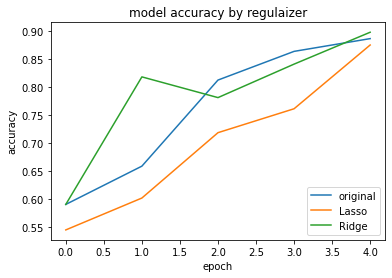

In [20]:
plt.plot(history1.history['accuracy'])
plt.plot(history_regulizerL1Val.history['accuracy'])
plt.plot(history_regulizerL2Val.history['accuracy'])
plt.title('model accuracy by regulaizer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['original', 'Lasso', 'Ridge'], loc='lower right')
plt.show()

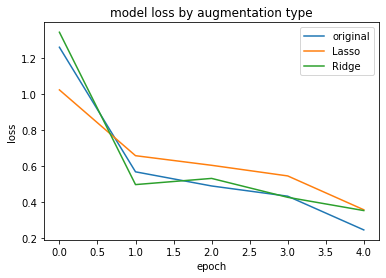

In [22]:
plt.plot(history1.history['loss'])
plt.plot(history_regulizerL1Val.history['loss'])
plt.plot(history_regulizerL2Val.history['loss'])
plt.title('model loss by augmentation type')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['original', 'Lasso', 'Ridge'], loc='upper right')
plt.show()